# Feed Forward Neural Network

Neural network is a machine learning paradigm which was inspired by nervous system of animals. It is a network of interconnected processing units, called neuron, which processes the input data and generates an output. The birth of neural network was in 1943 when Warren McCulloch and Walter Pitts, in their article “A logical calculus idea immanent in nervous activity” represented a computational model for the basic neuron and they proved that with a sufficient number of linked neurons any computable function can be approximated. 

**Multi-layer Perceptron**

The perceptron is the simplest form of neural network, which consists of a single neuron with adjustable synaptic weights and bias. The simplest and most commonly used structure of neural network is feedforward fully connected network. Feedforward means that data moves forward from input to output, not backwards or within one layer of the network. Multi-Layer Perceptron (MLP) is a class of Feedforward Neural Network, in which neurons are arranged in layers which may have different role in transforming the data. Layers are Input layer, Hidden layer and Output layer. The term “Hidden” refers to the fact that, these layers constitute the inner part of the network which are not seen directly from input and output of the neural network.
In this architecture, each neuron relates to all the neurons in the next layer and each connection has a weight. All the neurons, except the ones in input layer, have biases. The set of weights and biases constitute the parameters of the neural network. In each neuron, there is an activation function which is also called squashing or transferring function, and its role is to compute the output of the neuron given the set of input. The Identity function, step function and Sigmoidal function are examples of activation functions.


**Backpropagation**

The purpose of training of a neural network is to find the weights and biases which have the minimum error rate on validation data set. The most common method for training the MPLs is backpropagation which uses Gradient Descent.
Loss function measures the discrepancy between predicted values and real labels on training set. The main idea of backpropagation is to compute the gradient of the loss function, which is the direction of the greatest rate of increase in the function, based on neural network’s parameters (weights and biases) and then, move against this direction step by step, hoping to arrive to the minimum value of the loss function. As the result, the best values for the parameters will be exposed. One the requirement of back propagation is to have differentiable function like sigmoid as activation function in the neurons. 
The backpropagation algorithm is repetition of following steps:
<ul>  
  <li><b>Forward pass:</b>Compute the variables in hidden layers and output layer</li>
  <li><b>Backward pass:</b>Compute the error which is defined by cost function and compute the gradient, based on the neural network parameters θ1, θ2, … , θn
                                    $$\nabla J_θ = (\frac{\delta J}{\delta θ_1},\frac{\delta J}{\delta θ_2},...,\frac{\delta J}{\delta θ_n}) $$</li>
  <li><b>Parameters Update: </b> λ is learning rate 
                                    $$θ_i = θ_i- \lambda \frac{\delta J}{\delta θ_i} $$</li>
</ul>

Learning rate is normally a very small number. It determines the values of updates in each iteration. If a large value is selected as the learning rate, it is quite possible that the cost function does not converge to the minimum value. Because in each step, updates take a giant steps and it is possible, they overshoot the minimum value. If a very small value is selected for learning rate, then the training will be very slow. 


** Activation Function **

The primary choices for activation or transfer function on layers in Neural Network are the ones that are differentiable such as logistic, hyperbolic tangent and polynomial. The main choice is sigmoid function which is a special type of logistic function.  The formula for this function is:
$$f(x) = \frac{1}{1+e^{-x}} $$
This function suffers from two major problem which make the training of Neural Networks hard and time-consuming. The first problem is vanishing gradient. Vanishing gradient occurs when the layers close to the input have gradient close to zero and a large change in the parameters of early layer has a small effect on the output. This happens because sigmoid function maps all the numbers into the range between 0 and 1. The second problem is the density of the representation against the sparsity of the representation, because sigmoid never map any number to zero, as a result, all the neurons at each layer will be active.
Rectifier is another activation function which its formula is as:
$$f(x) = max(0,x) $$
Rectifier maps all the real number to range 0 and infinity, which addresses the problems, which are arisen by using sigmoid, that it does not suffer from vanishing descent and it gives a sparse representation.


** Dropout **

Dropout is a technique to prevent overfitting, which is a serious problems in deep neural networks.  Overfitting is a situation in which, the model follows the noises instead of the underlying relationship. Bagging is one of the methods to avoid overfitting by reducing the variance. It trains the model on different subset of training set, and to get the result on test set, it averages the result of each model on different subset. It would be very costly to follow the same method for neural networks specially if the network is very large. Dropout is a solution for addressing this problem. It is similar to bagging and related ensemble methods.
The key idea is, during training, some of the nodes along with their connections are dropped randomly. Like ensemble methods, this prevents the network to follow the noises by preventing nodes to co-adapting too much. Samples are taken from different thinned networks and during test time, the result is the average of these thinned networks.


** Neural Network in Julia **

In [37]:
using Knet, Plots, Images

include(Knet.dir("data","housing.jl"))
x,y = housing()
map(summary,(x,y))
predict(w,x) = w[1]*x .+ w[2]
loss(w,x,y) = mean(abs2,y-predict(w,x))
lossgradient = grad(loss);
predict(w,x) = w[1]*x .+ w[2]
loss(w,x,y) = mean(abs2,y-predict(w,x))
lossgradient = grad(loss);

function train!(w, data; lr=.1)
    for (x,y) in data
        dw = lossgradient(w, x, y)
        for i in 1:length(w)
            w[i] -= lr * dw[i]
        end
    end
    return w
end

include(Knet.dir("data","mnist.jl"))
xtrn,ytrn,xtst,ytst = mnist()
Atype = gpu() >= 0 ? KnetArray{Float32} : Array{Float32}
dtst = minibatch(xtst,ytst,100;xtype=Atype); # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
dtrn = minibatch(xtrn,ytrn,100;xtype=Atype); # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
(x,y) = first(dtst)
ax = Array(x);

In [38]:
predict(w,x) = w[1]*mat(x) .+ w[2]  # Same as linreg except we need mat() to convert input 4D->2D before matmul
loss(w,x,ygold) = nll(predict(w,x),ygold); # nll is negative log likelihood
# Initialize model
wsoft=map(Atype, [ 0.1*randn(10,784), zeros(10,1) ]);
loss(wsoft, x, y);
nll(wsoft,dtst,predict);
accuracy(wsoft,dtst,predict);
softmodels = [ copy(train!(wsoft, dtrn)) for epoch=1:60 ];  # ~17 seconds
trnsoftloss = [ nll(w,dtrn,predict) for w in softmodels ];  # ~13 seconds
tstsoftloss = [ nll(w,dtst,predict) for w in softmodels ];  # ~2 seconds
trnsofterr = [ 1-accuracy(w,dtrn,predict) for w in softmodels ];  # ~12 seconds
tstsofterr = [ 1-accuracy(w,dtst,predict) for w in softmodels ];  # ~2 seconds

** Compare MLP loss with softmax loss **

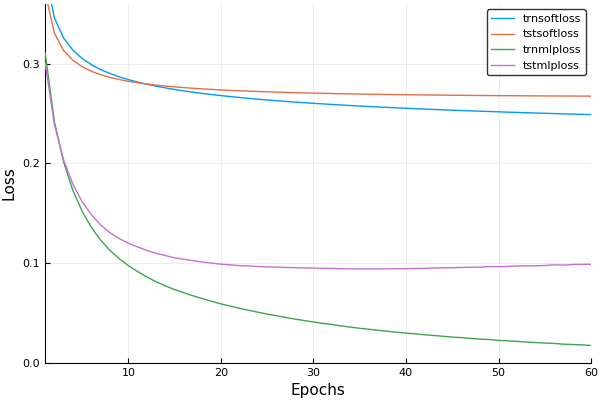

In [36]:
function predict(w,x)
    for i=1:2:length(w)
        x = w[i]*mat(x) .+ w[i+1]
        if i<length(w)-1
            x = max.(0,x)                         
        end
    end
    return x
end
wmlp=map(Atype, [ 0.1*randn(64,784), zeros(64,1), 
                  0.1*randn(10,64),  zeros(10,1) ])
loss(wmlp, x, y)  # average loss for random model should be close to log(10)=2.3026
mlpmodels = [ copy(train!(wmlp, dtrn)) for epoch=1:60 ]; # ~20 seconds
trnmlploss = [ nll(w,dtrn,predict) for w in mlpmodels ]; # ~12 seconds
tstmlploss = [ nll(w,dtst,predict) for w in mlpmodels ]; # ~2 seconds
plot([trnsoftloss tstsoftloss trnmlploss tstmlploss],ylim=(.0,.36),labels=[:trnsoftloss :tstsoftloss :trnmlploss :tstmlploss],xlabel="Epochs",ylabel="Loss")

** Compare MLP error with softmax error **

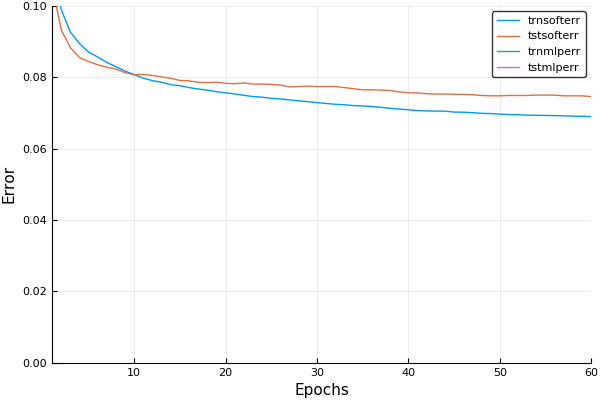

In [40]:
trnmlperr = [ 1-accuracy(w,dtrn,predict) for w in mlpmodels ]; # ~13 seconds
tstmlperr = [ 1-accuracy(w,dtst,predict) for w in mlpmodels ]; # ~2 seconds
plot([trnsofterr tstsofterr trnmlperr tstmlperr],ylim=(.0,.10),labels=[:trnsofterr :tstsofterr :trnmlperr :tstmlperr],xlabel="Epochs",ylabel="Error")

** Julia implementations **

Library:

<a href="https://github.com/denizyuret/Knet.jl">Knet.jl</a>

** References: **

[1] The Elements of Statistical Learning (Ch 11)